In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from utils import *

In [19]:
alpha = 0.1 
beta = 0.5
gamma = 0.8

idxconn = np.array([
    [1, 1,3,3],
    [0, 0,2,2],
    [1, 1,3,3],
    [0, 0,2,2],
])
dirconn = np.array([
    [[0,0],[-1,0],[0,0],[0,1]],
    [[0,0],[1,0],[0,0],[0,1]],
    [[0,0],[0,-1],[0,0],[1,0]],
    [[0,0],[0,-1],[0,0],[-1,0]],
])
s = System(4,idxconn, dirconn)
s.initialize([
    [alpha, beta, gamma],
    [alpha, beta, gamma],
    [alpha, beta, gamma],
    [alpha, beta, gamma],
])

In [20]:
def createBaseM(idxconn, dirconn, Nbase=4):
    Kbase = np.zeros([Nbase,Nbase])
    Wbase = np.zeros([Nbase,Nbase])
    for i in range(K):
        print()
    return 0


def createSys(N, s):
    K = np.zeros([N * s.Nbase * 3, N * s.Nbase * 3])
    W = np.zeros([N * s.Nbase * 3, N * s.Nbase * 3])
    for i in range(N):
        for j in range(N):
            K[0][0]=1
    return 0

In [21]:
class Matrix:
    def __init__(self, Nbase, indexConnections, dirconnections, dphi=0, Js=1, k_v=1, k_k=1, k_a=1, a=1, Nrep=3):
        self.Nbase = Nbase
        self.indexConnections=indexConnections
        self.directionConnections = dirconnections
        self.a=a
        self.k = [sym.symbols("k_x"), sym.symbols("k_y")]
        self.k_v = k_v
        self.k_k = k_k
        self.k_a = k_a
        self.dphi=dphi

        t = sym.symbols('t')
        self.auxvar=[
                sym.Function(r"\theta_a")(t),
                sym.Function(r"\phi_a")(t),
                sym.Function(r"\psi_a")(t),
        ]
        self.auxvar2 = [
            sym.Function(r"\theta_b")(t),
            sym.Function(r"\phi_b")(t),
            sym.Function(r"\psi_b")(t),
        ]
        self.auxeq = [
            sym.symbols(r"\alpha"),
            sym.symbols(r"\beta"),
            sym.symbols(r"\gamma"),
        ]
        self.auxeq2 = [
            sym.symbols(r"\alpha_2"),
            sym.symbols(r"\beta_2"),
            sym.symbols(r"\gamma_2"),
        ]

        self.eigenvecs=None
        self.eigenvals=None

        if type(Js)==int: self.Js = 0 * self.indexConnections + self.k_v # todos tienen el mismo J 
        else:
            self.Js = Js  # debe ser un arreglo con el J de cada conexion

    def setEquilibrium(self, eq):
        t = sym.symbols('t')

        self.equilibrium = eq
        self.variables = []
        for i in range(self.Nbase*3):
            aux = [
                sym.Function(r"\theta_{}".format(i))(t),
                sym.Function(r"\phi_{}".format(i))(t),
                sym.Function(r"\psi_{}".format(i))(t),
            ]
            self.variables.append(aux)


    def makeLagrangian(self):
            t = sym.symbols('t')

            Ls=[]

            for i in range(self.Nbase*3):
                kinetic = self.Kinetic(self.variables[i], self.equilibrium[i%self.Nbase])
                potential = 0
                potential += self.Anisotropy(self.variables[i], self.equilibrium[i%self.Nbase], i)
                for j in range(len(self.indexConnections[i%self.Nbase])):
                    idxconn = self.indexConnections[i%self.Nbase][j]
                    dirconn = self.directionConnections[i%self.Nbase][j]
                    
                    if i<self.Nbase:
                        if dirconn[0]==-1: continue
                        else: 
                            realidx = self.Nbase * dirconn[0] + idxconn
                    elif i>=2*self.Nbase: 
                        if dirconn[0]==1: continue
                        else: 
                            realidx = self.Nbase *(2+dirconn[0]) + idxconn
                    
                    else: realidx = self.Nbase*(1+dirconn[0]) + idxconn 

                    factor = sym.exp(sym.I * self.a * dirconn[1]*self.k[1])

                    if i==realidx:
                        var = []
                        for z in self.auxvar:
                            var.append(z)
                        potential += self.Potential(self.variables[i],self.equilibrium[i%self.Nbase], var, self.equilibrium[idxconn%self.Nbase], self.Js[i%self.Nbase][j])
                    else:
                        var=[]
                        for z in self.variables[realidx]:
                            var.append(z*factor)
                        potential += self.Potential(self.variables[i], self.equilibrium[i%self.Nbase], var,self.equilibrium[idxconn%self.Nbase], self.Js[i%self.Nbase][j])
                L = kinetic+potential
                Ls.append(L)

            self.lagrangians=Ls

    def equations(self):
        t = sym.symbols('t')

        self.E_L_equations=[]
        for i in range(self.Nbase*3):
            eq = sym.euler_equations(self.lagrangians[i], self.variables[i],t)
            self.E_L_equations.append(eq)

        # Replace varsaux por la variable correspondiente por el factor
        # esto solo es necesario si tenemos conexion a-a o b-b, etc
        
    def Kmatrix(self):
        t = sym.symbols('t')
        ddvar = []
        for i in self.variables:
            l = []
            for j in i:
                l.append(j.diff(t,2))
            ddvar.append(l)

        self.K = coefficients(self.E_L_equations, self.variables)
        self.W = -1*coefficients(self.E_L_equations, ddvar) # el -1 es por dt^2 -> -w^2

    def Wmatrix(self):
        newvar = []
        for i in range(self.Nbase*3):
            newvar.append(
                [
                    sym.symbols("a_{}".format(i)),
                    sym.symbols("b_{}".format(i)),
                    sym.symbols("c_{}".format(i)),
                ]
            )

        eqs = []
        for leq in self.E_L_equations:
            l = []
            for eq in leq:
                x = eq
                for i in range(self.Nbase*3):
                    for j in range(3):
                        ddvar = self.variables[i][j].diff(t, 2)
                        x = x.subs(ddvar, newvar[i][j])
                l.append(x)
            eqs.append(l)

        self.W = -1*coefficients(eqs, newvar)

    def seriesExpansion(self):
        epsilon = sym.symbols(r"\epsilon")
        littleauxvar1 = [
            self.auxeq[0] + epsilon*self.auxvar[0],
            self.auxeq[1] + epsilon*self.auxvar[1],
            self.auxeq[2] + epsilon*self.auxvar[2],
        ]
        littleauxvar2 = [
            self.auxeq2[0] + epsilon*self.auxvar2[0],
            self.auxeq2[1] + epsilon*self.auxvar2[1],
            self.auxeq2[2] + epsilon*self.auxvar2[2],
        ]
        R1 = R(littleauxvar1[0], littleauxvar1[1], littleauxvar1[2])
        R2 = R(littleauxvar2[0], littleauxvar2[1], littleauxvar2[2])

        # self.V = sym.series(V(self.k_v, R1, R2),epsilon, 0, 3).removeO().subs(epsilon,1)
        # self.K = sym.series(K(self.k_k, R1),epsilon, 0, 3).removeO().subs(epsilon,1)
        self.V = V(self.k_v, R1, R2).diff(epsilon, 2).subs(epsilon,0)
        self.K = K(self.k_k, R1).diff(epsilon, 2).subs(epsilon,0)
        self.A = Anis(self.k_a, R1, self.auxeq, self.auxeq2[0]).diff(epsilon, 2).subs(epsilon,0)
        
    def Potential(self, angles1,eq1, angles2, eq2, k):
        return self.V.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxvar2[0], angles2[0]),(self.auxvar2[1], angles2[1]),(self.auxvar2[2], angles2[2]),
            (self.auxeq2[0], eq2[0]),(self.auxeq2[1], eq2[1]),(self.auxeq2[2], eq2[2]),
            (self.k_v, k)
            ])

    def Kinetic(self, angles1, eq1):
        return self.K.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            ])
    
    def Anisotropy(self, angles1, eq1, idx):
        return self.A.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxeq2[0], ((-1)**idx)*self.dphi),
        ])

In [22]:
def buildM(K, W, N):
    newK = np.zeros([N*12,N*12], dtype=complex)
    newW = np.zeros([N*12,N*12], dtype=complex)
    for i in range(1, N-1):
        newK[12*i:12*(i+1), 12*i:12*(i+1)] = K[12:24,12:24]
        # newK[12*i:12*(i+1), 12*i:12*(i+1)] = K[0:12,0:12]
        newK[12*i:12*(i+1), 12*(i-1):12*(i)] = K[12:24,0:12] 
        newK[12*(i-1):12*i, 12*i:12*(i+1)] = K[0:12,12:24]
        
        newW[12*i:12*(i+1), 12*i:12*(i+1)] = W[12:24,12:24]
        newW[12*i:12*(i+1), 12*(i-1):12*(i)] = W[12:24,0:12] 
        newW[12*(i-1):12*i, 12*i:12*(i+1)] = W[0:12,12:24]

    # newK[0:12,0:12] = K[0:12,0:12]
    newK[0:12,12:24] = K[0:12,12:24]
    newK[12:24,0:12] = K[12:24,0:12]
    
    newW[0:12,0:12] = W[0:12,0:12]
    newW[0:12,12:24] = W[0:12,12:24]
    newW[12:24,0:12] = W[12:24,0:12]
    
    newK[(N-1)*12:N*12, (N-1)*12:N*12] = K[24:36,24:36]
    newW[(N-1)*12:N*12, (N-1)*12:N*12] = W[24:36,24:36]
    return newK, newW


In [23]:
    
def plot(eq, dphi, N, Nk=100):
    alpha, beta, gamma = eq

    idxconn = np.array([
        [1, 1, 3, 3],
        [0, 0, 2, 2],
        [1, 1, 3, 3],
        [0, 0, 2, 2],
    ])
    dirconn = [
        [[0,0],[-1,0],[0,0],[0,1]],
        [[0,0],[1,0],[0,0],[0,1]],
        [[0,0],[0,-1],[0,0],[1,0]],
        [[0,0],[0,-1],[0,0],[-1,0]],
    ]
    matriz = Matrix(4,idxconn, dirconn, dphi=dphi)
    matriz.setEquilibrium([
        [alpha, beta, gamma],
        [alpha, beta, gamma],
        [alpha, beta, gamma],
        [alpha, beta, gamma],
    ])
    matriz.seriesExpansion()
    matriz.makeLagrangian()
    matriz.equations()
    matriz.Kmatrix()
    matriz.Wmatrix()

    eigenvals = np.zeros([Nk, 12*N])
    ks = np.linspace(-np.pi, np.pi, Nk)
    for i in range(Nk):
        A_ = np.array(matriz.K.subs(matriz.k[1], ks[i]), dtype=complex)
        B_ = np.array(matriz.W.subs(matriz.k[1], ks[i]), dtype=complex)
        A , B = buildM(A_, B_, N)
        eig = sp.linalg.eig(A,B)
        # print(eig[0])
        eigenvals[i] = np.sort(eig[0])

    plt.plot(ks, eigenvals, color='black', linewidth=0.5)
    if abs(np.max(eigenvals))>1e5:
        plt.ylim((0,20))
    
    return eigenvals
    


C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


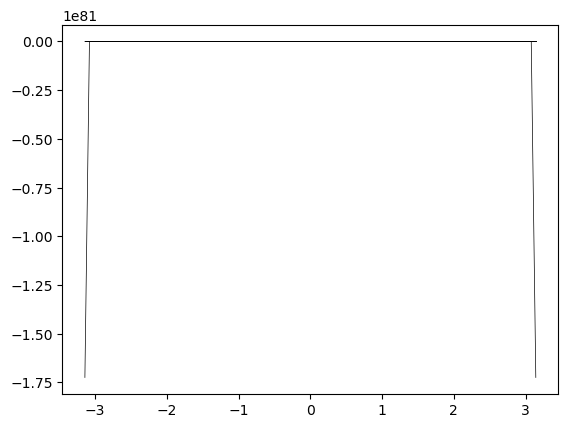

In [24]:
ks = np.linspace(-np.pi, np.pi, 100)
a = plot([0,0,0], 0, 10)


(-200.0, 200.0)

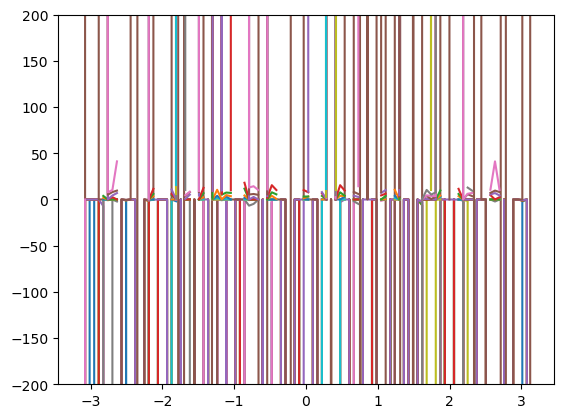

In [25]:
plt.plot(ks, a)
plt.ylim(-200,200)

C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


array([[-0.4       , -0.4       , -0.4       , ..., 13.93320077,
        13.93320077, 13.93320077],
       [-0.40514172, -0.40514172, -0.40514172, ..., 14.06009897,
        14.06009897, 14.06009897],
       [-0.41041197, -0.41041197, -0.41041197, ..., 14.18686968,
        14.18686968, 14.18686968],
       ...,
       [-0.41041197, -0.41041197, -0.41041197, ..., 14.18686968,
        14.18686968, 14.18686968],
       [-0.40514172, -0.40514172, -0.40514172, ..., 14.06009897,
        14.06009897, 14.06009897],
       [-0.4       , -0.4       , -0.4       , ..., 13.93320077,
        13.93320077, 13.93320077]])

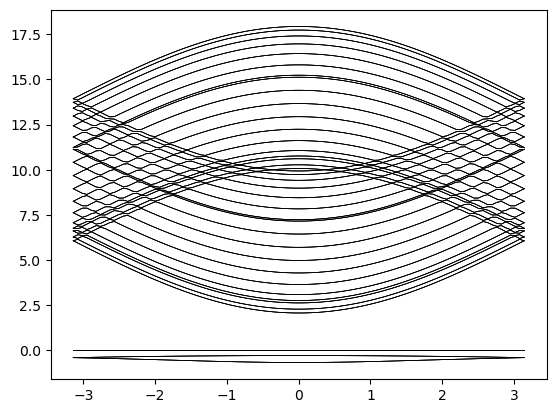

In [26]:
plot([0.1,0.5,0.8], 0, 10)


C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


array([[-0.62020186, -0.61209382, -0.50294576, ..., 12.29330815,
        12.4823155 , 12.48276019],
       [-0.62125656, -0.61233359, -0.50701782, ..., 12.36025125,
        12.41444461, 12.60509995],
       [-0.62419251, -0.61325427, -0.5135559 , ..., 12.23844111,
        12.53666033, 12.72779463],
       ...,
       [-0.62419251, -0.61325427, -0.5135559 , ..., 12.23844111,
        12.53666033, 12.72779463],
       [-0.62125656, -0.61233359, -0.50701782, ..., 12.36025125,
        12.41444461, 12.60509995],
       [-0.62020186, -0.61209382, -0.50294576, ..., 12.29330815,
        12.4823155 , 12.48276019]])

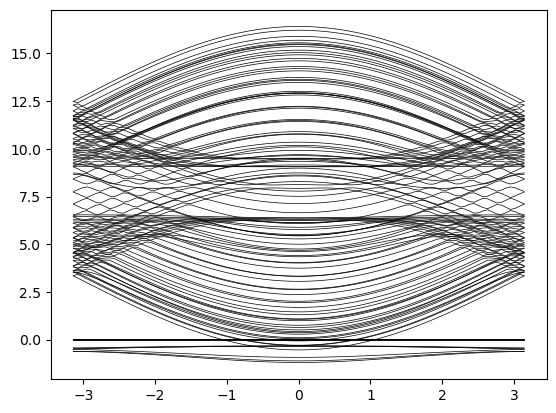

In [27]:
plot([0.1,0.5,0.8], 1.5, 10)


C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


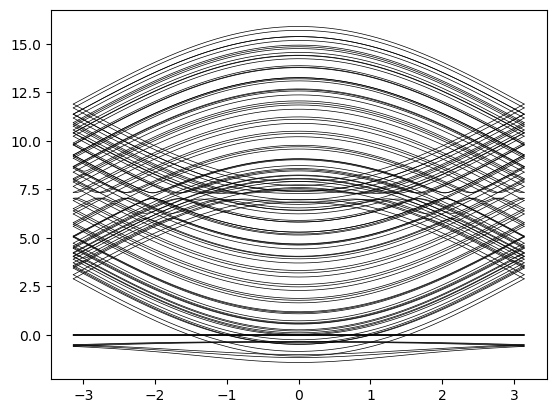

In [28]:
k3 = plot([np.pi/2,np.pi/2,np.pi/2], 1.5, 10, Nk=500)


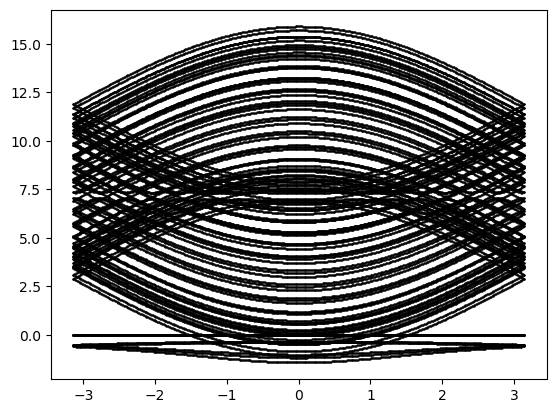

In [29]:
for i in range(len(k3[0])):
    plt.scatter(np.linspace(-np.pi, np.pi, 500), k3[:,i], color='black', s=0.4)

(5.5, 8.0)

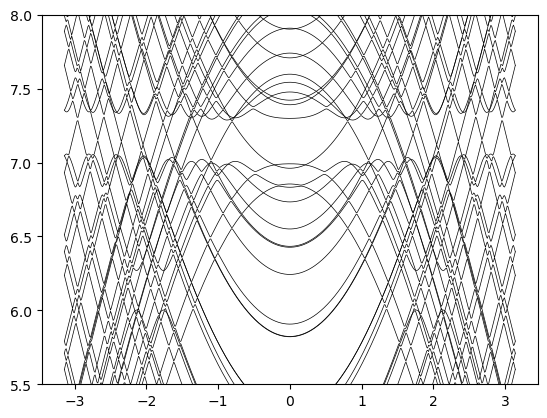

In [30]:
plt.plot(np.linspace(-np.pi, np.pi, 500), k3, linewidth=0.5, color='black')
plt.ylim(5.5,8)

C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


array([[-0.5       , -0.5       , -0.5       , ..., 11.93345858,
        11.93345858, 11.93345858],
       [-0.50805984, -0.50805984, -0.50805984, ..., 12.06035098,
        12.06035098, 12.06035098],
       [-0.51637527, -0.51637527, -0.51637527, ..., 12.18711607,
        12.18711607, 12.18711607],
       ...,
       [-0.51637527, -0.51637527, -0.51637527, ..., 12.18711607,
        12.18711607, 12.18711607],
       [-0.50805984, -0.50805984, -0.50805984, ..., 12.06035098,
        12.06035098, 12.06035098],
       [-0.5       , -0.5       , -0.5       , ..., 11.93345858,
        11.93345858, 11.93345858]])

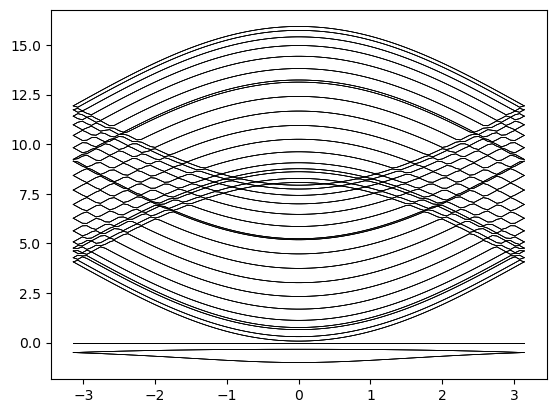

In [31]:
plot([np.pi/2,np.pi/2,np.pi/2], 2, 10)


C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


array([[-0.5       , -0.5       , -0.5       , ..., 11.93345858,
        11.93345858, 11.93345858],
       [-0.50805984, -0.50805984, -0.50805984, ..., 12.06035098,
        12.06035098, 12.06035098],
       [-0.51637527, -0.51637527, -0.51637527, ..., 12.18711607,
        12.18711607, 12.18711607],
       ...,
       [-0.51637527, -0.51637527, -0.51637527, ..., 12.18711607,
        12.18711607, 12.18711607],
       [-0.50805984, -0.50805984, -0.50805984, ..., 12.06035098,
        12.06035098, 12.06035098],
       [-0.5       , -0.5       , -0.5       , ..., 11.93345858,
        11.93345858, 11.93345858]])

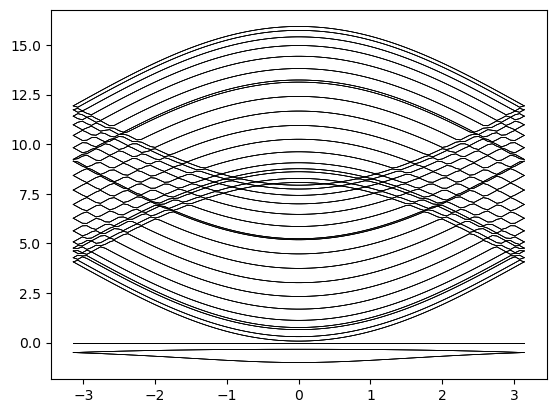

In [32]:
plot([np.pi/2,np.pi/2,np.pi/2], 3, 10)


C:\Users\gdela\AppData\Local\Temp\ipykernel_5696\1934415756.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvals[i] = np.sort(eig[0])


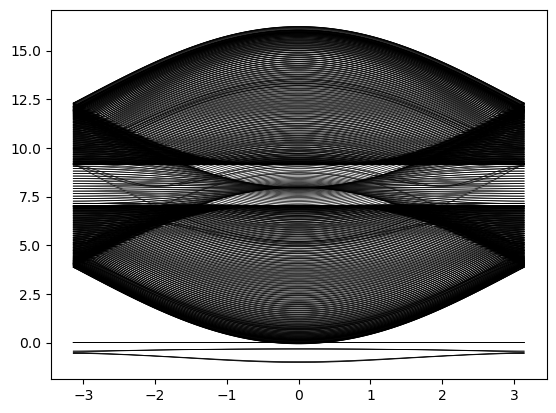

In [33]:
b2 = plot([np.pi/2,np.pi/3,np.pi/2], 1.5, 50)


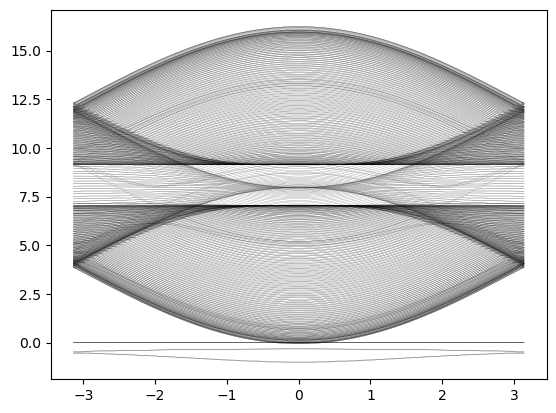

In [34]:
plt.plot(ks, b2, linewidth=0.1, color='black')